In [1]:
from GLC.data_loading.common import load_patch

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import annotations
from pathlib import Path
from typing import Optional, Union, TYPE_CHECKING

import numpy as np
from PIL import Image
import tifffile

In [3]:
df_obs_train = pd.read_csv("../data/observations/observations_fr_train.csv", sep=";", index_col="observation_id", nrows = 10000)

In [4]:
df_obs_train.species_id.values

array([241, 101, 700, ..., 727, 234,  70], dtype=int64)

In [5]:
observation_ids = df_obs_train.index

In [6]:
image = load_patch(observation_ids[0], "../data", data="all")
image[0]

array([[[ 66,  86,  61],
        [ 71,  91,  66],
        [ 76,  96,  71],
        ...,
        [ 71,  88,  69],
        [ 76,  93,  74],
        [ 83, 100,  81]],

       [[ 74,  94,  69],
        [ 75,  95,  70],
        [ 76,  96,  71],
        ...,
        [ 78,  95,  76],
        [ 82,  99,  80],
        [ 86, 103,  84]],

       [[ 79,  99,  74],
        [ 76,  96,  71],
        [ 73,  93,  68],
        ...,
        [ 79,  97,  75],
        [ 81,  99,  77],
        [ 82, 100,  78]],

       ...,

       [[ 73,  78,  55],
        [ 83,  88,  65],
        [ 98, 103,  80],
        ...,
        [123, 113, 103],
        [131, 118, 109],
        [133, 120, 111]],

       [[ 91, 100,  69],
        [101, 110,  79],
        [115, 122,  91],
        ...,
        [115, 103,  91],
        [120, 106,  97],
        [131, 117, 108]],

       [[101, 111,  76],
        [104, 114,  79],
        [104, 114,  79],
        ...,
        [118, 104,  93],
        [111,  97,  88],
        [113,  99,  90]]

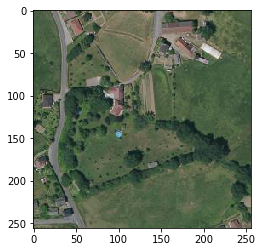

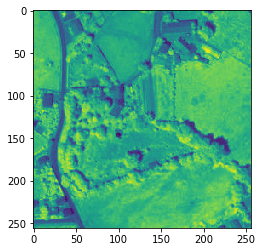

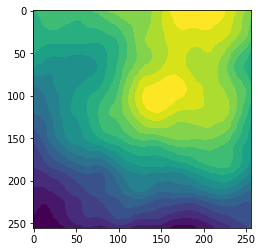

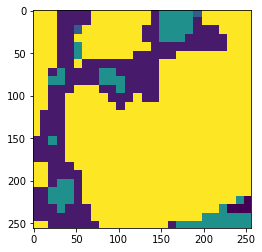

In [7]:
for i in range(0, len(image)):
    plt.imshow(image[i], interpolation='nearest')
    plt.show()

In [8]:
training_data = []
training_label = df_obs_train.species_id.values
for i in observation_ids:
    training_data.append(load_patch(i, "../data", data="rgb")[0])

In [9]:
##for image in training_data:
##    plt.imshow(image, interpolation='nearest')
##    plt.show()
##print(len(training_data), len(training_label))

In [10]:
import os
import torch
import numpy as np
from torch import from_numpy
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [11]:
def load_landcover(
    observation_id: Union[int, str],
    patches_path: Union[str, Path]
) -> Patches:

    observation_id = str(observation_id)

    region = "patches-fr"
    subfolder1 = observation_id[-2:]
    subfolder2 = observation_id[-4:-2]

    filename = Path(patches_path) / region / subfolder1 / subfolder2 / observation_id

    rgb_filename = filename.with_name(filename.stem + "_rgb.jpg")
    rgb_patch = Image.open(rgb_filename)
    transform = transforms.Compose([transforms.PILToTensor()])
  
    img_tensor = transform(rgb_patch)
    return img_tensor

class CustomImageDataset(Dataset):
    
    def __init__ (self,transform=None, target_transform=None):
        self.img_labels = pd.read_csv("../data/observations/observations_fr_train.csv", sep=";", index_col="observation_id", nrows = 10000).species_id.values
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        image = load_landcover(observation_ids[index], "../data")
        label = self.img_labels[index]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

In [12]:
from GLC.data_loading.pytorch_dataset import GeoLifeCLEF2022Dataset
longdataset = GeoLifeCLEF2022Dataset("../data",subset = "train", 
                                 region = 'fr', 
                                 patch_data = 'rgb', \
                                 use_rasters = False,\
                                 #transform = get_train_transforms(),\
                                 transform = None)

train_size = int(0.005 * 0.8 * len(longdataset))
val_size = len(longdataset) - train_size


t1, t2 = torch.utils.data.random_split(longdataset, [train_size, val_size])
train_dataset, val_dataset = torch.utils.data.random_split(t1, [int(0.8 * len(t1)), len(t1) - int(0.8 * len(t1))])
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=16,num_workers = 0,shuffle = True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers = 0,shuffle = False,drop_last=True)

2100


In [13]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import gc


from torchvision.models.resnet import ResNet, BasicBlock


import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
N_classes = 17036
class ResNetGeolife(ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3], num_classes=N_classes)

        self.conv1 = nn.Conv2d(256, 64, kernel_size=7, stride=1, padding=3, bias=False)

        
net = ResNetGeolife().to(device)

In [15]:
optimizer = torch.optim.Adam(net.parameters(),lr = 0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = net.to(device)

def loss_fn(preds, labels):
    #print (preds)
    #print(labels)
    loss = nn.CrossEntropyLoss()(preds, labels)
    #loss = nn.BCEWithLogitsLoss()
    return loss

In [16]:
def train(model, optimizer,  train_loader, val_loader, epochs=2, device='cpu'):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.float()
            targets = targets.to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            inputs = inputs.to(device)
            
            output = model(inputs) 
            
            loss = nn.CrossEntropyLoss(ignore_index = -1)
            loss = loss(output, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss += loss.item() 
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.float()
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            #inputs = np.repeat(inputs[..., np.newaxis], 3, -1)
            #if inputs.size(1) > 3:
            #    inputs = inputs.permute(0,3,2,1)
                
            inputs = inputs.to(device)
            #inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            #valid_loss += loss.data.item()*inputs.size(0)
            valid_loss += loss.item() 
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
           
            num_correct += torch.sum(correct).item()
            
            num_examples += correct.shape[0]
           
        valid_loss /= len(val_loader.dataset)
        
        try:
            x =  num_correct/num_examples
        except ZeroDivisionError:
            x = 0
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, '
              'accuracy = {:.2f}'.format(epoch+1, training_loss, valid_loss, x))

In [17]:


gc.collect()



0

In [ ]:
train(model.to(device), optimizer, train_loader, val_loader, epochs=2, device=device)

In [ ]:
test_dataset = GeoLifeCLEF2022Dataset("../data" ,subset = "test", 
                                 region = 'fr', 
                                 patch_data = 'rgb', \
                                 use_rasters = False,\
                                 transform = None
                                 )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle = False)

In [ ]:
len(test_dataset)
train_size = int(0.05 * 0.8 * len(test_dataset))
val_size = len(test_dataset) - train_size
test_data, t2 = torch.utils.data.random_split(test_dataset, [train_size, val_size])